In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
basin = np.load("../data/basin_iwaki_gosho.npz")
basin.keys()

KeysView(NpzFile '../data/basin_iwaki_gosho.npz' with keys: basin, lon, lat)

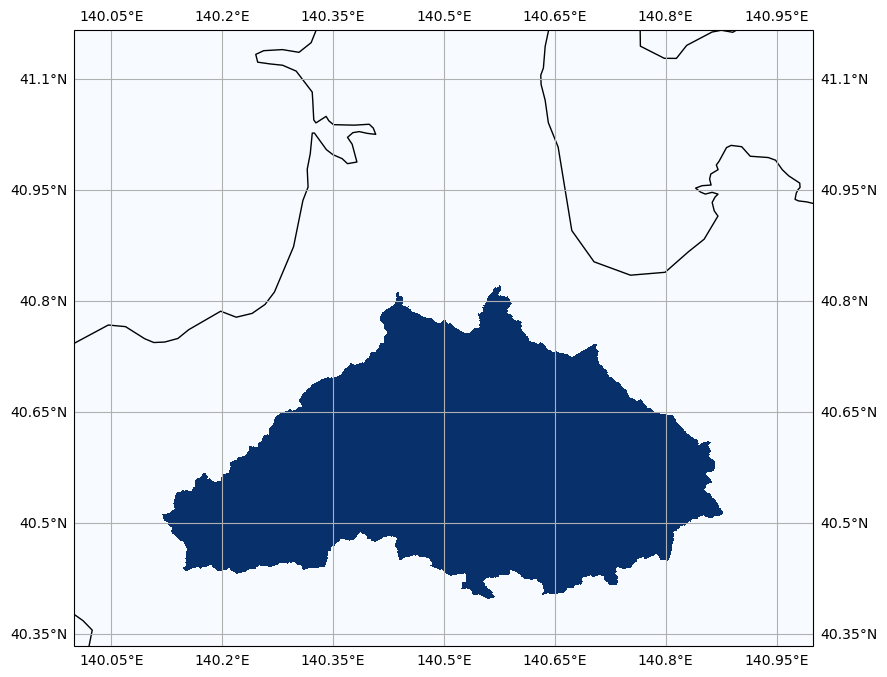

In [105]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(
    basin["lon"],
    basin["lat"],
    basin["basin"],
    vmin=0,
    vmax=0.1,
    transform=ccrs.PlateCarree(),
    cmap="Blues",
)

ax.coastlines(color="k")
ax.gridlines(draw_labels=True)

plt.show()

In [34]:
import pygrib
import matplotlib.pyplot as plt

In [3]:
gpv_file = pygrib.open(
    "../data/2018/Z__C_RJTD_20180915120000_EPSG_GPV_Rjp_Gll0p375deg_Lsurf_FD0000-3400_EM-13_grib2.bin"
)

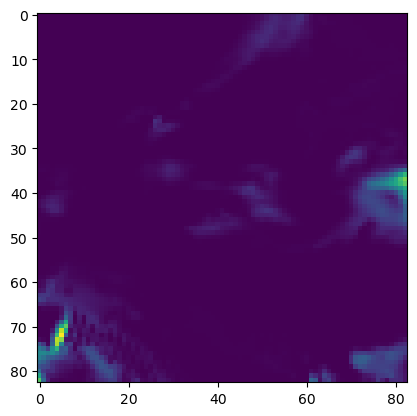

In [35]:
plt.imshow(gpv_file.message(18).values)

In [127]:
# 利用可能なすべてのnameとshortNameを表示する
gpv_file.seek(0)
for i, msg in enumerate(gpv_file):
    print(f"メッセージ {i+1}: name={msg.name}, shortName={msg.shortName}")

メッセージ 1: name=10 metre U wind component, shortName=10u
メッセージ 2: name=10 metre V wind component, shortName=10v
メッセージ 3: name=2 metre temperature, shortName=2t
メッセージ 4: name=2 metre relative humidity, shortName=2r
メッセージ 5: name=Pressure reduced to MSL, shortName=prmsl
メッセージ 6: name=unknown, shortName=unknown
メッセージ 7: name=10 metre U wind component, shortName=10u
メッセージ 8: name=10 metre V wind component, shortName=10v
メッセージ 9: name=2 metre temperature, shortName=2t
メッセージ 10: name=2 metre relative humidity, shortName=2r
メッセージ 11: name=unknown, shortName=unknown
メッセージ 12: name=Pressure reduced to MSL, shortName=prmsl
メッセージ 13: name=unknown, shortName=unknown
メッセージ 14: name=10 metre U wind component, shortName=10u
メッセージ 15: name=10 metre V wind component, shortName=10v
メッセージ 16: name=2 metre temperature, shortName=2t
メッセージ 17: name=2 metre relative humidity, shortName=2r
メッセージ 18: name=unknown, shortName=unknown
メッセージ 19: name=Pressure reduced to MSL, shortName=prmsl
メッセージ 20: name=unknown, s

In [128]:
# 降水量関連のメッセージを探す（複数の単語で検索）
gpv_file.seek(0)
keywords = ["rain", "precipitation", "precip", "tp", "rainfall"]
for i, msg in enumerate(gpv_file):
    found = False
    for keyword in keywords:
        if keyword.lower() in msg.name.lower() or (
            hasattr(msg, "shortName") and keyword.lower() in str(msg.shortName).lower()
        ):
            found = True
            break

    if found:
        print(f"\nメッセージ {i+1} の詳細情報:")
        print(f"name: {msg.name}")
        print(f"shortName: {msg.shortName}")
        print(f"parameterNumber: {msg.parameterNumber}")
        print(f"parameterCategory: {msg.parameterCategory}")
        print(f"typeOfLevel: {msg.typeOfLevel}")
        print(f"level: {msg.level}")
        print("-------------------------")

パラメーター指定で見つかったメッセージ数: 3536
11:Total precipitation:kg m-2 (accum):regular_ll:surface:level 0:fcst time 0-3 hrs (accum):from 201809151200:hi res cntl fcst

メッセージ 18 の内容:
18:Total precipitation:kg m-2 (accum):regular_ll:surface:level 0:fcst time 0-6 hrs (accum):from 201809151200:hi res cntl fcst


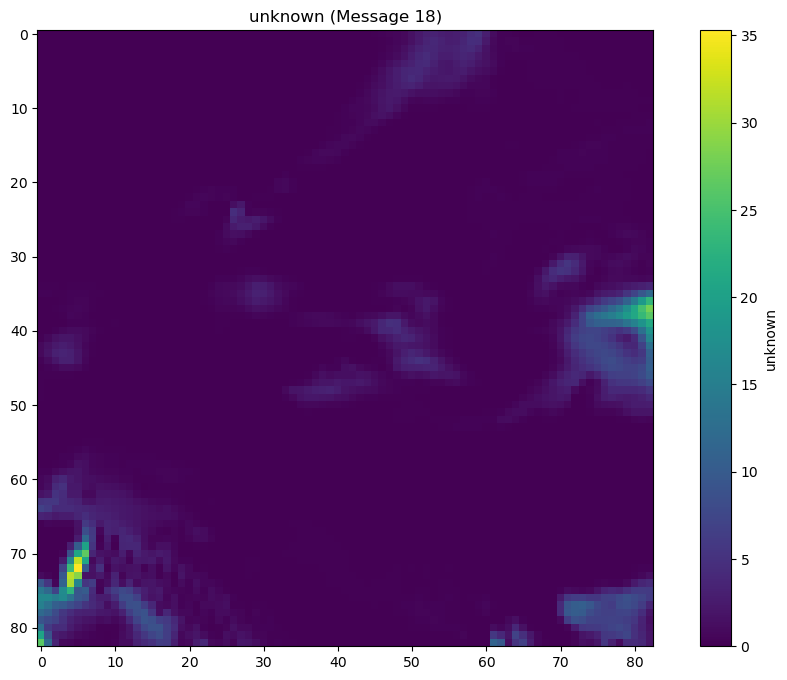

In [129]:
# 代替方法1: パラメーターカテゴリと番号で降水量を取得
gpv_file.seek(0)
try:
    # 一般的に降水量は category=1 (Moisture), parameterNumber=8 (Total Precipitation)
    precip_msgs = gpv_file.select(parameterCategory=1, parameterNumber=8)
    print(f"パラメーター指定で見つかったメッセージ数: {len(precip_msgs)}")
    if len(precip_msgs) > 0:
        print(precip_msgs[0])
except:
    print("パラメーター指定での取得に失敗しました")

# 代替方法2: メッセージ番号を直接指定
# 前のセルの結果を確認して降水量と思われるメッセージ番号を入力
msg_number = 18  # これは例です。適切な番号を結果から選んでください
try:
    msg = gpv_file.message(msg_number)
    print(f"\nメッセージ {msg_number} の内容:")
    print(msg)

    # データの可視化
    plt.figure(figsize=(12, 8))
    plt.imshow(msg.values)
    plt.colorbar(label=f"{msg.name}")
    plt.title(f"{msg.name} (Message {msg_number})")
    plt.show()
except:
    print(f"メッセージ番号 {msg_number} の取得に失敗しました")

In [130]:
# 様々な方法で降水量データを取得する
gpv_file.seek(0)

# 方法1: shortNameを使用（tp = total precipitation の略称）
try:
    tp_msgs = gpv_file.select(shortName="tp")
    print(f"shortName='tp'で取得したメッセージ数: {len(tp_msgs)}")
    if len(tp_msgs) > 0:
        print(tp_msgs[0])

        # データ可視化
        plt.figure(figsize=(10, 8))
        plt.imshow(tp_msgs[0].values)
        plt.colorbar(label="Total Precipitation")
        plt.title(f"{tp_msgs[0].name} (shortName={tp_msgs[0].shortName})")
        plt.show()
except Exception as e:
    print(f"shortNameでの取得エラー: {e}")

# 方法2: typeOfLevelとlevelを指定
try:
    level_msgs = gpv_file.select(typeOfLevel="surface")
    print(f"\ntypeOfLevel='surface'で取得したメッセージ数: {len(level_msgs)}")
    # 見つかったメッセージのnameを表示
    for i, msg in enumerate(level_msgs[:5]):  # 最初の5つだけ表示
        print(f"{i+1}: {msg.name} (shortName={msg.shortName})")
except Exception as e:
    print(f"typeOfLevelでの取得エラー: {e}")

shortNameでの取得エラー: no matches found

typeOfLevel='surface'で取得したメッセージ数: 7085
1: unknown (shortName=unknown)
2: unknown (shortName=unknown)
3: unknown (shortName=unknown)
4: unknown (shortName=unknown)
5: unknown (shortName=unknown)


In [131]:
# 代替方法1: パラメーターカテゴリと番号で降水量を取得
gpv_file.seek(0)
try:
    # 一般的に降水量は category=1 (Moisture), parameterNumber=8 (Total Precipitation)
    precip_msgs = gpv_file.select(parameterNumber=8)
    print(f"パラメーター指定で見つかったメッセージ数: {len(precip_msgs)}")
    if len(precip_msgs) > 0:
        print(precip_msgs[0])
except:
    print("パラメーター指定での取得に失敗しました")

パラメーター指定で見つかったメッセージ数: 3536
11:Total precipitation:kg m-2 (accum):regular_ll:surface:level 0:fcst time 0-3 hrs (accum):from 201809151200:hi res cntl fcst


In [144]:
gpv_file.seek(0)
precip_msgs = gpv_file.select(parameterName="Total precipitation")

In [150]:
precip_msgs[-1].perturbationNumber

6

In [ ]:
# 代替方法1: パラメーターカテゴリと番号で降水量を取得
gpv_file.seek(0)
try:
    # 一般的に降水量は category=1 (Moisture), parameterNumber=8 (Total Precipitation)
    precip_msgs = gpv_file.select(parameterCategory=1, parameterNumber=8)
    print(f"パラメーター指定で見つかったメッセージ数: {len(precip_msgs)}")
    if len(precip_msgs) > 0:
        print(precip_msgs[0])
except:
    print("パラメーター指定での取得に失敗しました")

In [51]:
from osgeo import gdal, gdal_array, gdalconst
import numpy as np

rivmouth = {}
rivmouth["iwaki"] = (1159, 3465)
rivmouth["iwaki_gosho"] = (1571, 4280)
d1 = gdal.Open("../data/upa/n41e140_upa.tif", gdalconst.GA_ReadOnly)
d2 = gdal.Open("../data/upa/n40e140_upa.tif", gdalconst.GA_ReadOnly)
lon1, dlon1, _, lat1, dlat1, _ = d1.GetGeoTransform()
lon2, dlon2, _, lat2, dlat2, _ = d2.GetGeoTransform()

print(lon1, dlon1, _, lat1, dlat1, _)
print(lon2, dlon2, _, lat2, dlat2, _)
d1_values = d1.GetRasterBand(1).ReadAsArray()
d2_values = d2.GetRasterBand(1).ReadAsArray()

d_merged = np.concatenate([d1_values, d2_values], axis=0)
fig = plt.figure(figsize=(20, 20), dpi=600)
plt.imshow(d_merged, vmin=0, vmax=0.1)
plt.plot(rivmouth["iwaki"][0], rivmouth["iwaki"][1], color="red", markersize=20, marker="o")
plt.plot(
    rivmouth["iwaki_gosho"][0], rivmouth["iwaki_gosho"][1], color="green", markersize=20, marker="o"
)
plt.show()

In [80]:
d_merged[rivmouth["iwaki"][::-1]]

2466.144

In [81]:
d_merged[rivmouth["iwaki_gosho"][::-1]]

1693.9487